In [1]:
%matplotlib notebook
from python_app.sp_digitiser import SpDigitiser
from python_app.power_pipeline import PowerPipeline
from python_app.g1_pipeline import G1Pipeline
from python_app.utils import file_ops
import os

# Power measurements
- **Length in ns**. Converted to `SP_POINTS = length / 2.5ns`
- **Repetitions**. Split up into batches of `R_POINTS` (rounded to 1000 for optimised kernel performance) to the digitiser.

In [ ]:
TIME_IN_NS = 5000
AVERAGES = 1_000_00

R_POINTS = 253952
SP_POINTS = 200
R_POINTS_PER_GPU_CHUNK = 1024
NO_RUNS = 100

pp = PowerPipeline(
    ipython=True,
    time_in_ns=TIME_IN_NS, averages=AVERAGES
#     R_POINTS=R_POINTS, SP_POINTS=SP_POINTS, R_POINTS_PER_GPU_CHUNK=R_POINTS_PER_GPU_CHUNK, NO_RUNS=NO_RUNS
)

In [2]:
RUN_NAME = "repetition-5MHz_width-180ns"

chA_background=None; chB_background=None
# (chA_background, chB_background) = file_ops.load_chA_chB_arrays("./dump/ttt.csv")

pp.execute_run(
    NO_RUNS=30,
    digitiser_parameters={
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 53,
        "channelB_offset": 38,
#         "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_EXTERNAL_10MHZ_REFFERENCE
    },
    run_name=RUN_NAME,
    chA_background=chA_background, chB_background=chB_background
)

POWER-PIPELINE: Overriding number of runs 4 -> 30
SP-DIGITISER:   Max Trigger frequency: 340kHz
SP-DIGITISER:   External clock source used!
SP-DIGITISER:   External trigger used!
POWER-PIPELINE: Measurements started


0% [██████████████████████████████] 100% | ETA: 00:00:00

POWER-PIPELINE: Measurements done -> data dumped to ./store/repetition-5MHz_width-180ns.csv
SP-DIGITISER:   🕱 Disconnected from digitiser.



Total time elapsed: 00:00:45


In [ ]:
import matplotlib.pyplot as plt
plt.savefig(f"./dump/{RUN_NAME}.pdf")

# G1 measurements
- **Tau points** to evaluate the correlation for. Starting from 0

G1-PIPELINE:    Building kernel with:
TAU_POINTS=100
RUNS=100



<IPython.core.display.Javascript object>


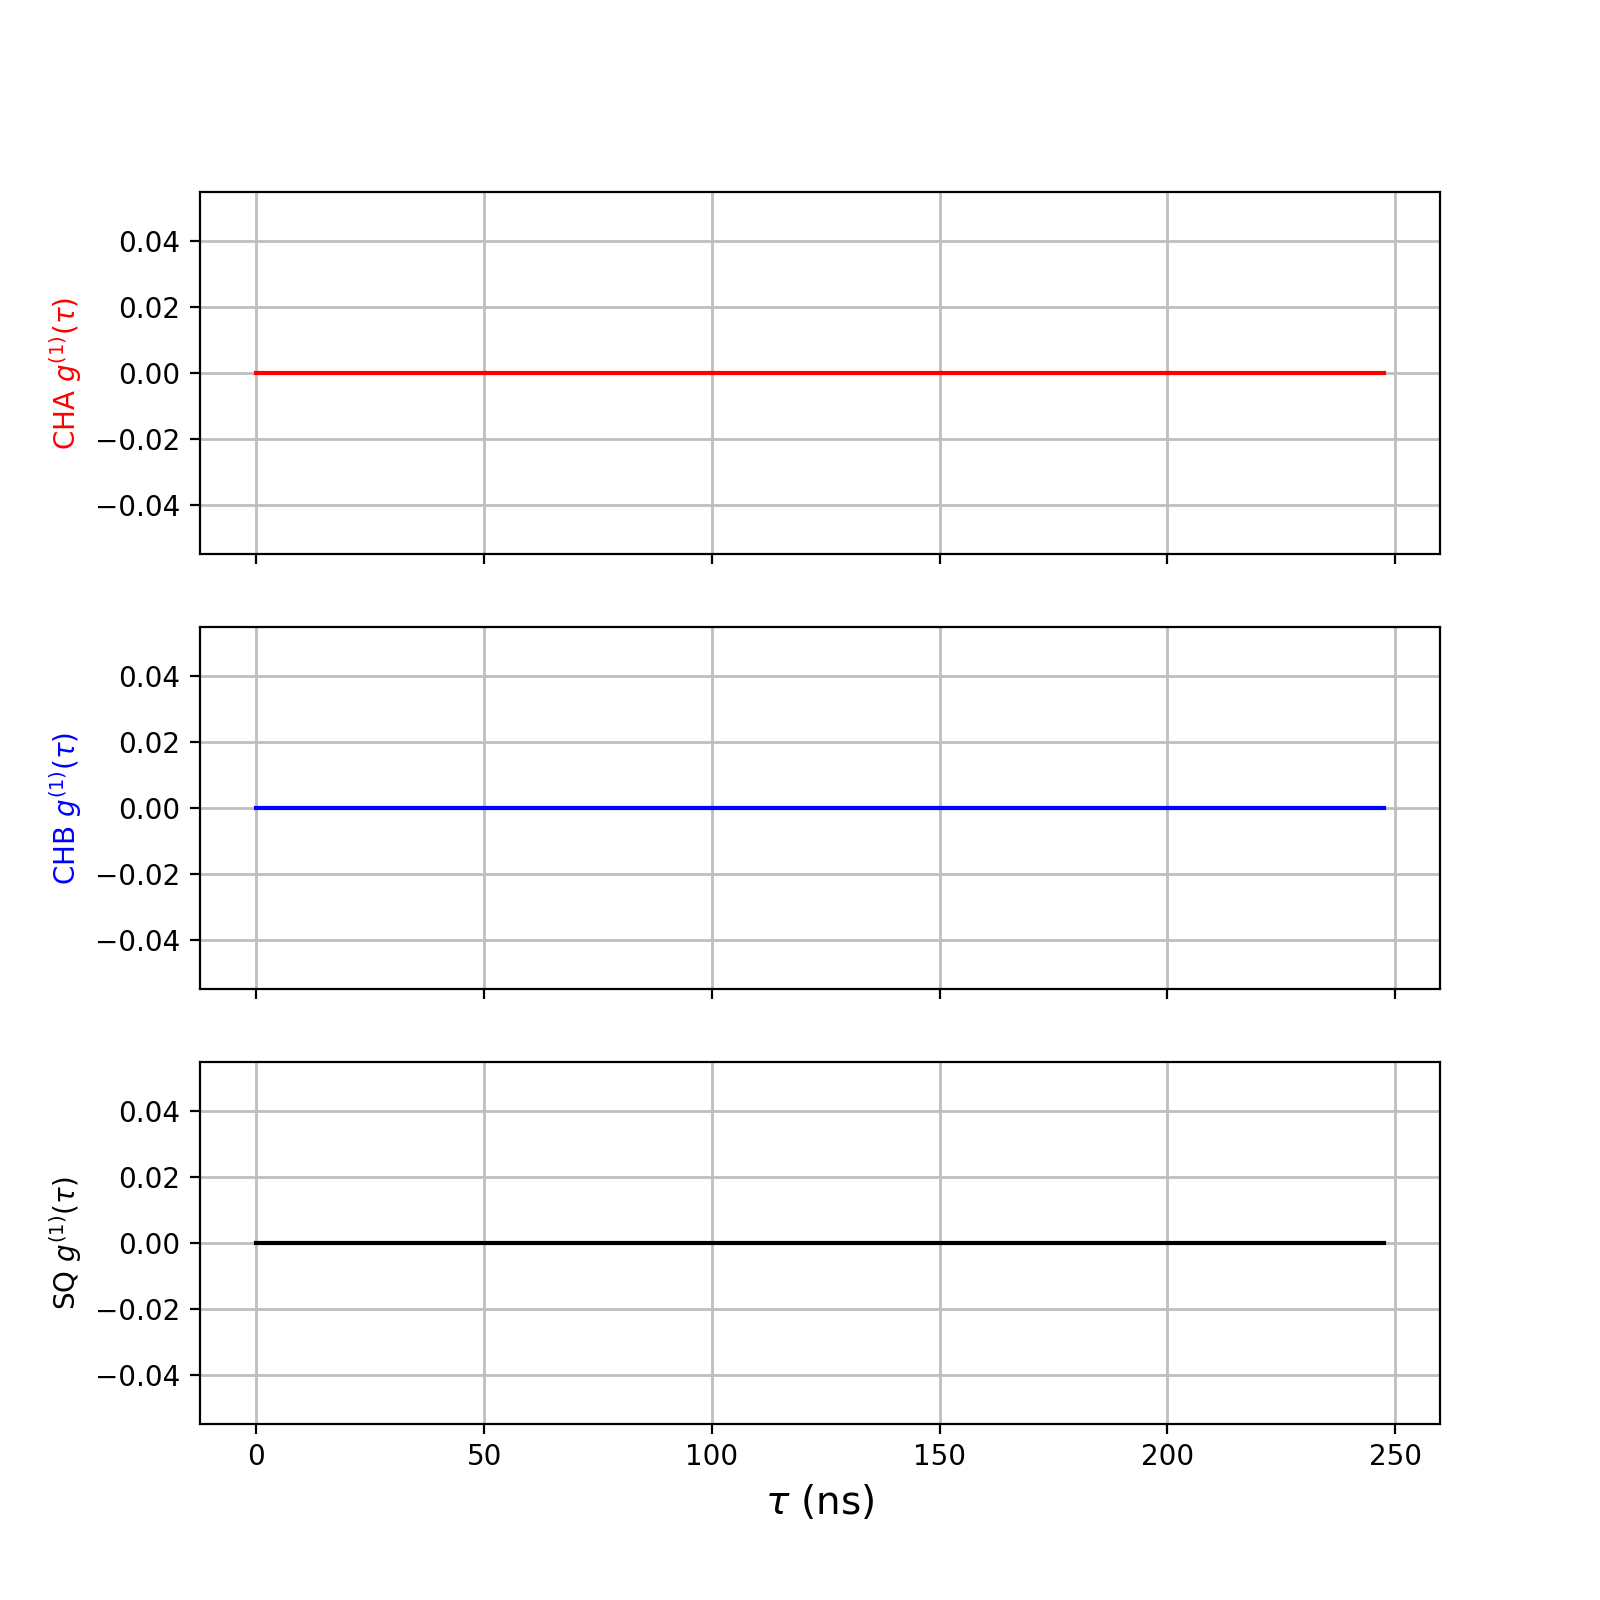

In [2]:
TAU_POINTS = 100
NO_RUNS = 100

pp = G1Pipeline(
    ipython=True,
    NO_RUNS=NO_RUNS,
    TAU_POINTS=TAU_POINTS,
    recompile=False
)

In [ ]:
# Kernel must be relaunched if running in jupyter notebook in order to free the dll library being used
os._exit(0)

# Debug

## Fetching from digitiser

In [1]:
%matplotlib notebook
import ctypes
import numpy as np
import python_app.utils.library_manager as library_manager
from python_app.sp_digitiser import SpDigitiser
import matplotlib.pyplot as plt

library_manager.build_library({}, "libadq")
ADQAPIia = ctypes.cdll.LoadLibrary("./csrc/bin/ADQAPIia.so")
ADQAPI = ctypes.cdll.LoadLibrary("libadq.so")

📡  [***] Building digitiser library ./bin/ADQAPIia.so
g++ -DLINUX -std=c++11 -Wno-write-strings -Iinclude  -I/usr/local/cuda-11.0/include  -L/usr/local/cuda-11.0/lib64  -I./../Celero/include  -L./../Celero/build  -ladq    -lcudart  -lfftw3 -lfftw3_threads -fPIC -shared -o ./bin/ADQAPIia.so ./src/sp_digitiser.cpp ./src/logging.cpp
📡  [***] Done



In [2]:
R_POINTS = 1
SP_POINTS = 200000

spd = SpDigitiser(
    {
        "r_points": R_POINTS,
        "sp_points": SP_POINTS,
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE
    }
)

chA_buff = np.zeros(SP_POINTS, dtype=np.short)
chB_buff = np.zeros(SP_POINTS, dtype=np.short)

assert ADQAPI.ADQ214_MultiRecordSetup(
    spd.adq_cu_ptr,
    1,
    R_POINTS,
    SP_POINTS,
)

ADQAPIia.fetch_digitiser_data(
    spd.adq_cu_ptr,
    chA_buff.ctypes.data, chB_buff.ctypes.data,
    SP_POINTS,
    R_POINTS
)

SP-DIGITISER:   Max Trigger frequency: 6.1kHz
SP-DIGITISER:   External trigger used!


1

In [5]:
len([
    0,
    4352,
    892,
    -2045,
    -2292,
    -1258,
    -2482,
    -2406,
    -635,
    1900,
    3064,
    342,
    1516,
    2727,
    2438,
    1450,
    -1270,
    -2198,
    -1652,
    -3066,
    4210,
    993,
    -206,
    -2241,
    -790,
    -902,
    -2372,
    1006,
    -559,
    -794,
    -31,
    -1183,
    -2917,
    1874,
    -1473,
    -3359,
    -3599,
    851,
    771,
    -815,
    703,
    -1451,
    2533,
    -444,
    1057,
    -2656,
    1023,
    1864,
    1654,
    -556,
    2810,
    -2246,
    959,
    -950,
    -121,
    -1355,
    -2409,
    -825,
    693,
    1017,
    2173,
    -4051,
    323,
    859,
    -837,
    949,
    320,
    1611,
    -850,
    -3421,
    543,
    1703,
    2333,
    1135,
    -894,
    -2004,
    -3063,
    1237,
    1207,
    1791,
    -2737,
    -1248,
    1316,
    1668,
    792,
    4204,
    -175,
    -1172,
    -2830,
    -1264,
    979,
    3874,
    -2283,
    -1235,
    -2604,
    -3659,
    792,
    1455,
    -1268,
    1123,
    -2736,
    3276,
    -1092,
    694,
    -308,
    944,
    -1321,
    -2676,
    -1623,
    918,
    -2249,
    -309,
    -938,
    2283,
    1314,
    1489,
    658,
    -2636,
    57,
    1085,
    -1996,
    2437,
    2319,
    3722,
    -100,
    1182,
    -607,
    3690,
    -470,
    2503,
    -3339,
    -381,
    -2998,
    2477,
    916,
    -864,
    328,
    -1352,
    -2213,
    -3287,
    880,
    -1775,
    -4612,
    -528,
    -707,
    1247,
    2113,
    -1300,
    1908,
    -3583,
    -154,
    2975,
    2258,
    873,
    -1713,
    -4819,
    -882,
    -2776,
    -2880,
    1065,
    1047,
    -3676,
    -1346,
    1626,
    -3708,
    1322,
    -1084,
    298,
    -1455,
    -1610,
    -452,
    -1720,
    956,
    -4487,
    -4489,
    -405,
    3808,
    -729,
    878,
    3370,
    2230,
    -1236,
    -615,
    -2690,
    483,
    -979,
    -3416,
    -2151,
    772,
    4239,
    1885,
    1537,
    -3711,
    -3425,
    536,
    -3602,
    -2393,
    1285,
    3236,
    -3604,
    -899,
    -233,
    -2975,
    501,
    703,
    -95,
    -1357,
    -665,
    251,
    2317,
    -1879,
    1157,
    -1604,
    -907,
    -3267,
    -584,
    -594,
    1777,
    466,
    -1407,
    -3588,
    -291,
    939,
    287,
    -4101,
    -871,
    -312,
    286,
    682,
    3433,
    -1143,
    -523,
    -860,
    4995,
    1981,
    1657,
    454,
    778,
    -1600,
    2471,
    -1200,
    714,
    -1095,
    146,
    -921,
    2953,
    -1926,
    1345,
    -2504,
    -446,
    -632,
    -3368,
    -1517,
    2833,
    2623,
    -241,
    1456,
    -568,
    919,
    -750,
    1638,
    3809,
    237,
    -622,
    -15,
    156,
    863,
    -2501,
    1896,
    -938,
    1703,
    5250,
    -71,
    21,
    -4008,
    -1189,
    -2775,
    -1139,
    710,
    902,
    4288,
    -2183,
    -1875,
    2817,
    -610,
    1605,
    4044,
    -3668,
    -883,
    -596,
    -316,
    965,
    1618,
    1705,
    -1751,
    -2507,
    -2114,
    -495,
    3182,
    -1898,
    -1085,
    -843,
    1764,
    3355,
    1528,
    -2685,
    -1807,
    -1116,
    -1231,
    4597,
    1023,
    -3158,
    -383,
    -562,
    -1764,
    3452,
    353,
    1642,
    527,
    -80,
    -3139,
    -1462,
    -1301,
    1363,
    -4359,
    1080,
    -120,
    1894,
    3747,
    -60,
    2686,
    -4190,
    -883,
    -2469,
    4781,
    1018,
    -183,
    -2271,
    -840,
    684,
    3335,
    1224,
    -1734,
    3553,
    1191,
    -2276,
    2443,
    0,
    1848,
    1749,
    2099,
    -502,
    -2185,
    1169,
    572,
    1866,
    -2028,
    -946,
    -2224,
    2824,
    1019,
    -2901,
    -1939,
    575,
    -917,
    701,
    1739,
    -1323,
    448,
    -1594,
    -344,
    -868,
    224,
    501,
    3849,
    -3364,
    -666,
    1538,
    1975,
    789,
    355,
    2573,
    -933,
    -231,
    4697,
    553,
    29,
    1723,
    -1936,
    -737,
    262,
    -1096,
    2064,
    -3375,
    1962,
    -1010,
    1798,
    -2636,
    1039,
    -1970,
    -826,
    -1022,
    -3730,
    895,
    619,
    -113,
    729,
    -660,
    1009,
    983,
    28,
    1805,
    -3979,
    -1198,
    -396,
    -2375,
    -651,
    671,
    365,
    -2969,
    -1014,
    1465,
    -2920,
    802,
    -1898,
    -917,
    -372,
    2648,
    364,
    206,
    1128,
    -1051,
    -207,
    -2779,
    -2020,
    3574,
    -65,
    -34,
    -1884,
    -291,
    -1594,
    3878,
    858,
    2673,
    -2794,
    -927,
    1194,
    -2854,
    1493,
    2731,
    -196,
    -517,
    -3290,
    1995,
    3051,
    -1572,
    3015,
    -2548,
    279,
    2524,
    -1239,
    582,
    170,
    -1566,
    -817,
    -1402,
    3876,
    788,
    3672,
    1133,
    -438,
    2559,
    -2556,
    -327,
    3083,
    -2335,
    -2446,
    -152,
    2649,
    3053,
    1374,
    3532,
    1519,
    -51,
    -3801,
    -2614,
    971,
    428,
    711,
    -803,
    -3326,
    4862,
    240,
    -3263,
    -2699,
    -2256,
    -2941,
    179,
    1897,
    -1284,
    -216
])

501

<IPython.core.display.Javascript object>


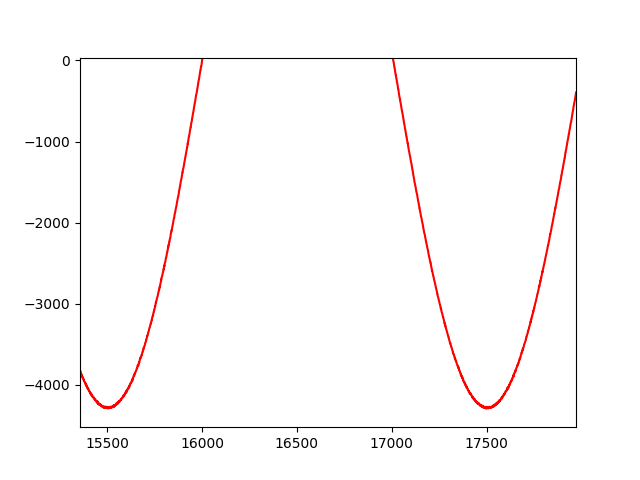

In [3]:
fix, ax = plt.subplots(1)
ax.plot(chA_buff, color="red")

<IPython.core.display.Javascript object>


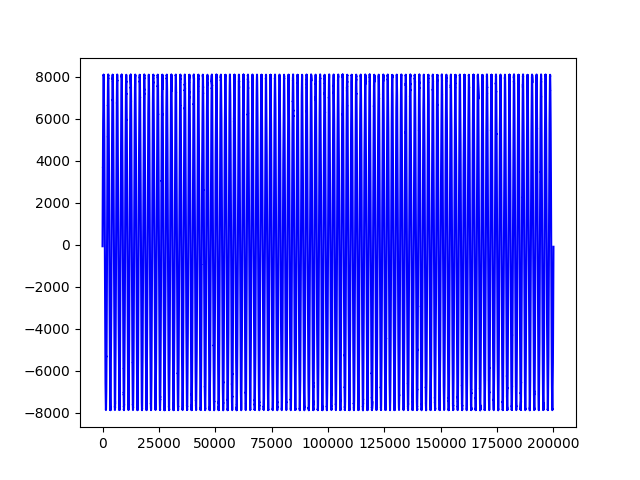

In [4]:
fix, ax = plt.subplots(1)
ax.plot(chB_buff, color="blue")

## Library testing

In [1]:
import ctypes

import numpy as np
from python_app.sp_digitiser import SpDigitiser
from python_app.utils import library_manager

LIBRARY_LOCATION = "./csrc/bin/libia.so"
SP_POINTS = 20
R_POINTS = 2
R_POINTS_PER_GPU_CHUNK = 1

In [2]:
library_manager.build_library(
    {
        "R_POINTS_PER_GPU_CHUNK": str(R_POINTS_PER_GPU_CHUNK),
        "SP_POINTS": str(SP_POINTS),
        "R_POINTS": str(R_POINTS),
    }
)

🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=20 -D R_POINTS=2 -D R_POINTS_PER_GPU_CHUNK=1

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src/power_kernel_cpu.cpp ⟶ build/./src/power_kernel_cpu.o
🍕 [cpp] Building src/logging.cpp ⟶ build/./src/logging.o
🍕 [cpp] Building src/power_pipeline.cpp ⟶ build/./src/power_pipeline.o


In [2]:
chA = np.ones(SP_POINTS, dtype=np.short)

chB = np.ones(SP_POINTS, dtype=np.short)

In [3]:
libia = ctypes.cdll.LoadLibrary(LIBRARY_LOCATION)

chA[0] = 30
chA[1] = 40
print(chA.ctypes.data)
# for (i, _) in enumerate(chA):
#     chA[i] = i
# for (i, _) in enumerate(chB):
#     chB[i] = i-2

spd = SpDigitiser(
    {
        "r_points": R_POINTS,
        "sp_points": SP_POINTS,
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    }
)

21137328
SP-DIGITISER:   Trigger frequency: 1300kHz
SP-DIGITISER:   External trigger used!
SP-DIGITISER:   0


In [6]:
library_manager.HANDLE_CPP_ERROR(
    libia.run_power_measurements(
        spd.adq_cu_ptr,
        chA.ctypes.data, chB.ctypes.data,
        1,
        ctypes.create_string_buffer("./debug-run.csv".encode("utf-8"), size=40)
    )
)